In [1]:
import torch
import torch.nn as nn

import time

import numpy as np
import matplotlib.pyplot as plt

/Users/yiyang/miniconda3/envs/cv_proj/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
data_path = '../'
prefix = 'balan'
full_data = torch.load(data_path + prefix + '_data_small.pt')
full_label = torch.load(data_path + prefix + '_label.pt')

full_size = full_data.size(0)



In [3]:
# TODO: split into training and testing 80%-20%
indices = torch.randperm(full_size)
train_size = int(full_size * 0.8)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = full_data[train_indices]
train_label = full_label[train_indices]
test_data = full_data[test_indices]
test_label = full_label[test_indices]

In [4]:
train_data = train_data / 255
test_data = test_data / 255

In [5]:
# show size
print("Training data, ", train_data.size(), "Type", train_data.type())
print("Training label,", train_label.size())



Training data,  torch.Size([15641, 3, 32, 32]) Type torch.FloatTensor
Training label, torch.Size([15641])


In [6]:
train_data_size = train_data.size(0)
print(train_data_size)
print(train_data.is_contiguous())

15641
True


## Utility Functions
- display num param
- show image

- get error
- evaluate on test data

In [7]:
# Util func
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

In [8]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')


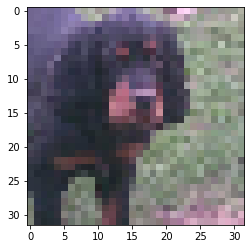

tensor(7)


In [11]:
show(train_data[100])
print(train_label[100])

In [12]:
def get_error( scores , labels ):
    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

In [13]:
def eval_on_test_set():
    test_size = test_data.size(0)

    running_error=0
    num_batches=0

    for i in range(0,(test_size//bs)*bs,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        inputs = (minibatch_data - mean)/std

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

## Build CNN
A VGG-liked CNN Structure

In [14]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

In [15]:
net=VGG_convnet()
print(net)
display_num_param(net)

VGG_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(i

In [16]:
mean= train_data.mean()

In [17]:
std= train_data.std()

## Define Hyper-parameters

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam( net.parameters() , lr=0.01 )
bs= 50

## Training

In [19]:
start=time.time()

for epoch in range(10):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(train_data_size)
 
    for count in range(0, (train_data_size//bs)*bs ,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # normalize the minibatch (this is the only difference compared to before!)
        inputs = (minibatch_data - mean)/std
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    if epoch%1 == 0:
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')
    
    
        
        

epoch= 0 	 time= 293.5694830417633 	 loss= 533.2713452936747 	 error= 89.72435901180292 percent
test error  =  89.10256387331546 percent
 
epoch= 1 	 time= 615.5677139759064 	 loss= 2.303027969140273 	 error= 89.8397435935644 percent
test error  =  89.10256387331546 percent
 
epoch= 2 	 time= 953.1880187988281 	 loss= 2.3034029664137425 	 error= 89.7756410523867 percent
test error  =  89.10256387331546 percent
 


KeyboardInterrupt: 

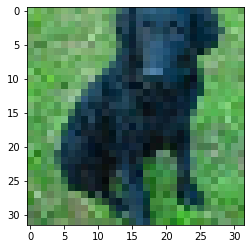

In [24]:
show(test_data[0])